<a href="https://colab.research.google.com/github/ShimonMalnick/ComputerVision/blob/master/MnistClassifier/MnistClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Network Architecture
1. Convolution layer of 32 filters with shape 5x5 (followed by Relu activation)
2. 2x2 Max pooling
3. Convolution layer of 64 filters with shape 5x5 (followed by Relu activation)
4. 2x2 Max pooling
5. Fully connected layer with output shape of 1024 (followed by Relu activation)
6. Classification layer - Fully connected layer with output shape of 10 (followed by softmax activation)

#Load the Dataset
First load the mnist dataset and organize it in batches of size 32

In [6]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D
from tensorflow.keras import Model

mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# Add a channels dimension
x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(10000).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)


#Construct the classifier

In [7]:
class MnistClassifier(Model):
  def __init__(self):
    super(MnistClassifier, self).__init__()
    self.conv1 = Conv2D(32, 5, activation='relu')
    self.max_pool1 = MaxPool2D(2)
    self.conv2 = Conv2D(64, 5, activation='relu')
    self.max_pool2 = MaxPool2D(2)
    self.flatten = Flatten()
    self.d1 = Dense(1024, activation='relu')
    self.d2 = Dense(10, activation='softmax')

  def call(self, x):
    x = self.conv1(x)
    x = self.max_pool1(x)
    x = self.conv2(x)
    x = self.max_pool2(x)
    x = self.flatten(x)
    x = self.d1(x)
    x = self.d2(x)
    return x

# Create an instance of the model
model = MnistClassifier()

#Define Loss Metric and Optimizer
I used cross entropy as the loss function, and used the Adam optimizer for the training process

In [8]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

optimizer = tf.keras.optimizers.Adam()

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')


#Training

In [9]:
@tf.function
def train_step(images, labels):
  with tf.GradientTape() as tape:
    predictions = model(images)
    loss = loss_object(labels, predictions)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  train_loss(loss)
  train_accuracy(labels, predictions)



@tf.function
def test_step(images, labels):
  predictions = model(images)
  t_loss = loss_object(labels, predictions)

  test_loss(t_loss)
  test_accuracy(labels, predictions)

EPOCHS = 5
train_err = []
test_err = []
for epoch in range(EPOCHS):
  i = 1
  for images, labels in train_ds:
    train_step(images, labels)
    if i % 500 == 0:
      for test_images, test_labels in test_ds:
        test_step(test_images, test_labels)
      train_err += [train_accuracy.result()*100]
      test_err += [test_accuracy.result()*100]
    i += 1

  template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
  print(template.format(epoch+1,
                        train_loss.result(),
                        train_accuracy.result()*100,
                        test_loss.result(),
                        test_accuracy.result()*100))

  # Reset the metrics for the next epoch
  train_loss.reset_states()
  train_accuracy.reset_states()
  test_loss.reset_states()
  test_accuracy.reset_states()


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 1, Loss: 0.09665427356958389, Accuracy: 97.00833892822266, Test Loss: 0.05286412313580513, Test Accuracy: 98.336669921875
Epoch 2, Loss: 0.03715238347649574, Accuracy: 98.84666442871094, Test Loss: 0.04045736789703369, Test Accuracy: 98.78666687011719
Epoch 3, Loss: 0.02549293264746666, Accuracy: 99.23999786376953, Test Loss: 0.031789809465408325, Test Accuracy: 99.06999969482422
Epoch 4, Loss: 0.018653560429811478, Accuracy: 99.41999816894531, Test Loss: 0.03155580163002014, Test Accuracy: 99.103

#Plotting the Accuracy

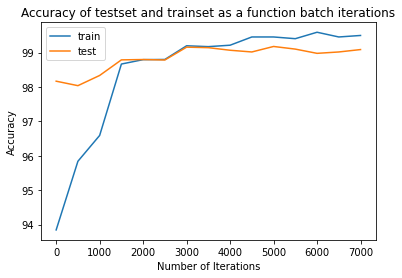

In [11]:
plt.figure()
plt.plot(np.arange(len(train_err)) * 500, train_err, label="train")
plt.plot(np.arange(len(test_err)) * 500, test_err, label="test")
plt.legend()
plt.xlabel('Number of Iterations')
plt.ylabel('Accuracy')
plt.title('Accuracy of testset and trainset as a function of batch iterations')
plt.show()